<a href="https://colab.research.google.com/github/Basma2423/Decision-Tree-From-Scratch/blob/main/Decision_Tree_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

***Reading and displaying the data***

In [ ]:
df = pd.read_csv('/content/PlayTennis.csv')
df.head()

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      14 non-null     object
 1   Temperature  14 non-null     object
 2   Humidity     14 non-null     object
 3   Wind         14 non-null     object
 4   Play Tennis  14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes


In [ ]:
df.describe()

,Outlook,Temperature,Humidity,Wind,Play Tennis
count,14,14,14,14,14
unique,3,3,2,2,2
top,Sunny,Mild,High,Weak,Yes
freq,5,6,7,8,9


***Function to calculate the entropy (impurity) of some distribution***

In [ ]:
# Takes the probabilies of a specific feature and calculate its entropy value
def calc_entropy(probabilities):

  entropy_sum = 0
  for p in probabilities:
    if p > 0:          # Avoid log(0) errors
      entropy_sum -= p * math.log2(p)

  return entropy_sum


***Function to calculate the average entropy of some column (feature)***

In [ ]:
def calc_avg_entropy(features, labels):
    """Calculate the average entropy of a feature."""
    total_samples = len(labels)
    unique_values = set(features)
    avg_entropy = 0.0
    for value in unique_values:

        value_labels = labels[features.values == value]
        total_value_count = len(value_labels)
        prob = total_value_count / total_samples
        yes_count = value_labels.value_counts().get('Yes' , 0)

        avg_entropy += prob * calc_entropy([yes_count/total_value_count, (1 - yes_count)/ total_value_count])

    return avg_entropy


***Function to calculate the information gain from choosing this feature***

In [ ]:
# Calculates the gain value of a feature
def gain(feature, labels, parent_probabilities):

  parent_entropy = calc_entropy(parent_probabilities)
  child_entropy = calc_avg_entropy(feature, labels)

  return parent_entropy - child_entropy

***Function to build the decision tree as a nested dictionary***

In [ ]:
def build_tree(data , target , max_depth = 5 , depth = 0):
  '''
  Takes the data, labels, and maximum depth.
  It builds the tree based on the maximum information gain of available features in each split.
  It stops when it reaches the pure split or exceeds the maximum depth.
  '''

  target_values = target.unique().tolist()
  if len(target_values) == 1 or depth == max_depth: # if the data is pure (only 1 label) or exceeds the max depth
    return target.mode()[0]  # return the most comman label

  total = len(target)
  parent_probabilities = target.value_counts() / total

  info_gains = []

  for feature in data.columns:
      info_gain = gain(data[feature], target, parent_probabilities.tolist()) # calculate the info gain for that feature
      info_gains.append(info_gain)


  best_feature = data.columns[np.argmax(info_gains)] # select maximum info gain feature
  tree = {best_feature: {}}

  for value in np.unique(data[best_feature]):
    subset_x = data[data[best_feature] == value].drop(columns = [best_feature]) # create a new subset data without best_feature
    subset_y = target[data[best_feature] == value] #create a new subset for corresponding labels
    tree[best_feature][value] = build_tree(subset_x , subset_y , max_depth , depth + 1)

  return tree


***Test the functions***

In [ ]:
target = df['Play Tennis']  # the labels
df_without_labels = df.drop(columns=['Play Tennis'])


In [ ]:
tree = build_tree(df_without_labels , target)
tree
'''
{'Outlook':
{
  'Overcast': 'Yes',
  'Rain': {
    'Wind': {
      'Strong': 'No', 'Weak': 'Yes'}},
  'Sunny': {
    'Humidity': {
      'High': 'No', 'Normal': 'Yes'
      }}}}
'''


"\n{'Outlook':\n{\n  'Overcast': 'Yes',\n  'Rain': {\n    'Wind': {\n      'Strong': 'No', 'Weak': 'Yes'}},\n  'Sunny': {\n    'Humidity': {\n      'High': 'No', 'Normal': 'Yes'\n      }}}}\n"

***Plotting the decision tree***

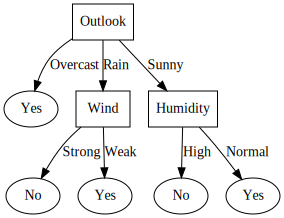

In [ ]:
from graphviz import Digraph
from IPython.display import display
from graphviz import Source

def plot_tree(tree, parent_name='', edge_label='', counter=0):
    counter += 1
    if isinstance(tree, str):  # leaf node
        node_name = f'node{counter}'
        graph.node(node_name, label=tree, shape='ellipse')
        graph.edge(parent_name, node_name, label=edge_label)
        return counter

    # internal node
    for feature in tree:
        node_name = f'node{counter}'
        graph.node(node_name, label=feature, shape='box')
        if parent_name:
            graph.edge(parent_name, node_name, label=edge_label)
        for value in tree[feature]:
            counter = plot_tree(tree[feature][value], node_name, str(value), counter)

    return counter

graph = Digraph()
plot_tree(tree)
graph.view()

dot_format = graph.source
s = Source(dot_format, filename="test.gv", format="png")
display(s)